## DS807: Applied machine learning
Christian M. Dahl. cmd@sam.sdu.dk.

### Generative adversarial nets

Notes: For the purpose of this notebook, DLWP refers to Deep Learning with Python by Francois Collet (ISBN10: 9781617294433).

## Introduction

*Generative adversarial nets* (GANs) are a type of procedure where two neural networks "battle" in besting each other. Specifically:

1. A *generator* attempts to create realistic data to fool the discriminator into thinking what it produces is real data.
1. A *discriminator* attempts to distinguish between real data and what the generator produces.

<img src="./graphics/IntroGANMNIST.png" alt="Drawing" style="width: 1000px;"/>


## Program

After this lecture, you will:

1. Know what a generative adversarial neural network is, including what roles the generator and the discriminator play.
1. Know what type of problems can be solved by using generative adversarial neural networks.
1. Be familiar with some of the difficulties of training GANs, as well as some tips to improve stability and performance.
1. Have applied your knowledge in order to train generative adversarial neural networks for modelling distributions and generating images.

## What is a GAN?

To understand in more details what a GAN is, let us consider the generator and discriminator separately, trying to understand their inputs and outputs$^1$.

**Generator**
<br>
The generator takes as input random noise. It then "transforms" this random noise into realistic data (such as an image). The random noise induces variation into the data it produces. *In many ways, this resembles the generator of a variational autoencoder, but now the noise is totally random*.

**Discriminator**
<br>
The discriminator takes as input data that is either real or fake (having been produced by the generator, in this case). It then outputs a "guess" of whether this is fake or real data. *This is exactly like any neural network for binary classification*.

GANs are due to "Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., ... & Bengio, Y. (2014). Generative adversarial nets. In Advances in neural information processing systems (pp. 2672-2680)".

$^1$Note that this is the basic approach. As will become evident, there are cases where somewhat different procedures are used.

## *Why* do we train GANs?

A question you might - indeed should - ask is *why* we are interested in training GANs. That is:
1. Which problems do they help us solve?
1. Are we interested in the generator, discriminator, or both? Why do we train both, if we are only interested in one of them?

Examples of GAN model applications: https://machinelearningmastery.com/impressive-applications-of-generative-adversarial-networks/

The types of problems GANs help us solve are generally problems where we are interested in modelling a distribution, or at least being able to sample from a distribution. This is the job of the generator, and it achieves this in an "unsupervised" fashion; that is, we do not train it with "labels" corrosponding to what it tries to produce, but rather train it to fool the discriminator. More on this later.

In most cases, the discriminator is purely auxiliary. It is trained in a "supervised" fashion to distinguish - or *discriminate* - between real and fake data. We are not actually interested in a model that is able to do this, but it can act as a "teacher" for the generator.

## Training a GAN

A training step typically resembles:
1. Sample random noise and have the generator generate fake data.
1. Mix the fake data with real data and have the discriminator distinguish between what is real and fake.
1. Use the predictions on the fake data as "feedback" to the generator.
1. Use all the predictions of the discriminator as "feedback" to itself.

As you may notice, this means we have two optimization problems - and these are not "aligned"!

So the correct way to think of this is we update the generator some, then the discriminator some, and so on and so forth. We cannot$^1$ start by finishing one optimization and then stepping on to the next etc.

**Note**: This means we have two models and use two different optimizers!

$^1$The proofs in the original GAN paper are made by full convergence of the discriminator between each generator step, but in practice this is not done. More common to do one step generator, then one step discriminator, etc. 

## Architecture of a GAN for image generation

<img src="./graphics/figure_8-15.png" alt="Drawing" style="width: 1200px;"/>
Source: "DLWP"

<img src="./graphics/goodfellow-et-al-14-algo-1.png" alt="Drawing" style="width: 800px;"/>
Source: "Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., ... & Bengio, Y. (2014). Generative adversarial nets. In Advances in neural information processing systems (pp. 2672-2680)."

## GANs are playing a game

The generator and discriminator of a GAN are essentially playing the following minimax game:

$\underset{G}{\texttt{min}}\,\underset{D}{\texttt{max}}\,V(D, G) = \mathbb{E}_{x\sim p_{\texttt{data}}(x)}[\texttt{log}\,D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[\texttt{log}\,(1 - D(G(z)))]$

Where $G$ and $D$ are the generator and discriminator, respectively.

**Intuition**: The two "players" are fighting in a setting where they can only improve by making the other player worse off.

**Remark**: Imagine the generator and discriminator are both perfect. Then $G$ has learned to model the true distribution and $D$ can only guess (being correct 50% of the time). This is what we hope to achieve when training GANs. This is known as the **Nash equilibrium** of the game.

**Note**: As will become clear later (next slide), we do not play this game exactly, but rather use a "heuristic" that works better in practice.

## Objectives in practice

<img src="./graphics/goodfellow-16-fig-12.PNG" alt="Drawing" style="width: 1000px;"/>

Source: "Goodfellow, I. (2016). NIPS 2016 tutorial: Generative adversarial networks. arXiv preprint arXiv:1701.00160."

## The generator gradually improves

<img src="./graphics/gan-progress.png" alt="Drawing" style="width: 1000px;"/>
Source: "https://www.tensorflow.org/tutorials/generative/dcgan"

## Essentially, this is the generator learning a distribution

<img src="./graphics/goodfellow-et-al-14-fig-1.png" alt="Drawing" style="width: 1000px;"/>

**Notes**: Blue line is the discriminator distribution, black points is the true data, and green line is the generator distribution.

Source: "Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., ... & Bengio, Y. (2014). Generative adversarial nets. In Advances in neural information processing systems (pp. 2672-2680)."

## Learning the (multivariate) normal distribution

Let's do something quite simple, but nonetheless illustrative. Specifically, we will see if our generator can learn to transform the standard normal to the normal distribution.

In [1]:
import time

import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt

generator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=(10,)) # 10 since a 10D normal distribution
])
discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(10,)),
    tf.keras.layers.Dense(1),
])

In [2]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [3]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

EPOCHS = 40
BATCH_SIZE = 128

def get_stats():
    noise = tf.random.normal([1000, 10]) # standard normal
    real = tf.random.normal([1000, 10], mean=7, stddev=3) # to non-standard normal
    
    fake = generator.predict(noise)
    
    discr_real_pred = tf.nn.sigmoid(discriminator.predict(real)).numpy()
    discr_fake_pred = tf.nn.sigmoid(discriminator.predict(fake)).numpy()
    
    acc_real = np.mean(discr_real_pred >= 0.5)
    acc_fake = np.mean(discr_fake_pred < 0.5)
                                    
    return np.mean(fake), np.sqrt(np.var(fake)), acc_real, acc_fake

In [4]:
@tf.function #Compiling the function into a static graph (for speed-up)
def train_step():
    noise = tf.random.normal([BATCH_SIZE, 10]) # standard normal
    real = tf.random.normal([BATCH_SIZE, 10], mean=7, stddev=3) # to non-standard normal

    # Open a GradientTape to record the operations run
    # during the forward pass, which enables auto-differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Run the forward pass of the layer.
        # The operations that the layer applies to its inputs are going to be recorded
        # on the GradientTape.
        generated = generator(noise, training=True)
        real_output = discriminator(real, training=True)
        fake_output = discriminator(generated, training=True)
        
        # Compute the loss values for this minibatch.
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, 
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                                discriminator.trainable_variables))

In [5]:
results = [('Before training', *get_stats())]

for epoch in range(1, EPOCHS + 1):
    print(f'Starting epoch: {epoch}.')
    
    for _ in range(5000): # steps pr epoch
        train_step()

    results.append((epoch, *get_stats()))

results_df = pd.DataFrame(results, columns=['Epoch', 'Mean', 'Std. Dev.', 'Acc., real', 'Acc., fake'])

32/32 [==============================] - 0s 2ms/step
Starting epoch: 1.
32/32 [==============================] - 0s 2ms/step
Starting epoch: 2.
32/32 [==============================] - 0s 2ms/step
Starting epoch: 3.
32/32 [==============================] - 0s 2ms/step
Starting epoch: 4.
32/32 [==============================] - 0s 2ms/step
Starting epoch: 5.
32/32 [==============================] - 0s 2ms/step
Starting epoch: 6.
32/32 [==============================] - 0s 2ms/step
Starting epoch: 7.
32/32 [==============================] - 0s 2ms/step
Starting epoch: 8.
32/32 [==============================] - 0s 2ms/step
Starting epoch: 9.
32/32 [==============================] - 0s 2ms/step
Starting epoch: 10.
32/32 [==============================] - 0s 4ms/step
Starting epoch: 11.
32/32 [==============================] - 0s 4ms/step
Starting epoch: 12.
32/32 [==============================] - 0s 2ms/step
Starting epoch: 13.
32/32 [==============================] - 0s 2ms/step
Startin

## Mean and standard deviation of generator

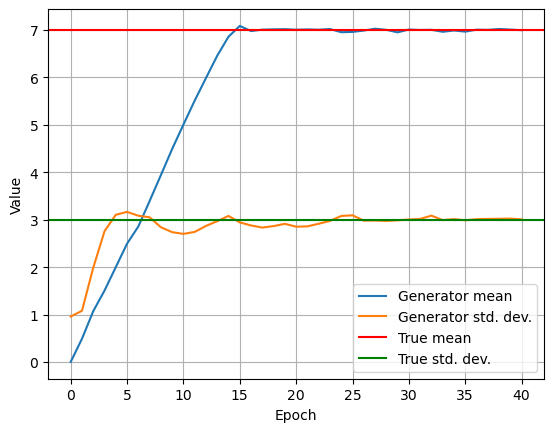

In [6]:
plt.plot(results_df['Mean'], label='Generator mean')
plt.plot(results_df['Std. Dev.'], label='Generator std. dev.')
plt.axhline(7, color='r', label='True mean')
plt.axhline(3, color='g', label='True std. dev.')
plt.grid()
plt.legend()
plt.xlabel('Epoch'),
plt.ylabel('Value')
plt.show()

## Accuracy of discriminator

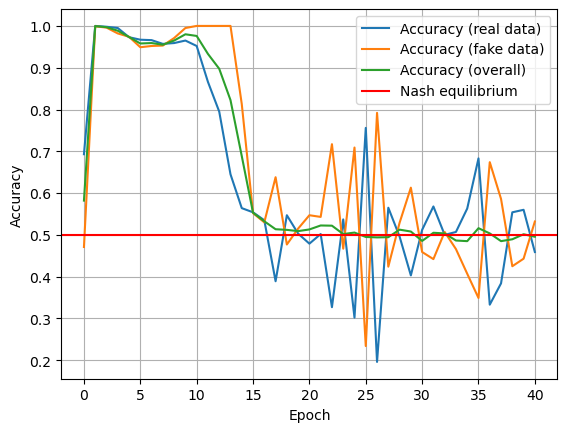

In [7]:
plt.plot(results_df['Acc., real'], label='Accuracy (real data)')
plt.plot(results_df['Acc., fake'], label='Accuracy (fake data)')
plt.plot(results_df[['Acc., real', 'Acc., fake']].mean(axis=1), label='Accuracy (overall)')
plt.axhline(0.5, color='r', label='Nash equilibrium')
plt.grid()
plt.legend()
plt.xlabel('Epoch'),
plt.ylabel('Accuracy')
plt.show()

## Exercises

1. You are curious if GANs are able to model just *any* multivariate normal distribution, so you decide to try a new dimensionality, mean, and standard deviation, and otherwise replicate the study from the slides.
1. As you mutter "very well, it might work, but we also start with a standard normal - in reality we are newer so close to the true distribution to start off!", you decide to model the noise from another distribution (such as the uniform distribution). Are you still able to model the true distribution?

**Hint**: You may use the notebook I have uploaded under this lecture as a starting point (exercise-gan-distribution.ipynb). It provides some of the code, and you then have to fill in the rest. You do not have to use it - it is there if you think it might be helpful!

## Why are we interested in learning generative models?

It might not be immediately obvious how powerful learning arbitrary distributions is. However, the following non-trivial problems might be solved with strong generative models:

1. Suppose we are interested in simulating possible futures, such as for planning or for reinforcement learning. Strong generative models may be able to realistically simulate such futures, i.e., model time series as in https://www.sciencedirect.com/science/article/pii/S0893608022003446?via%3Dihub. 
1. Suppose a small number of labelled and a large number of unlabelled data is available. GANs may be used in such cases for semi-supervised learning.
1. Suppose we want to model multi-modal distributions. More "directed" learning may be degenerate in such cases, but GANs are able to model such distributions.
1. As with autoencoders, it allows us to solve many similar problems, such as super resolution, art generation, and image-to-image translation.

I suggest reading https://arxiv.org/pdf/1701.00160.pdf for a great discussion of this and GANs in general (by Goodfellow, and the material I base this list and indeed much of these slides on).

## GANs are *difficult* to use

So far GANs sound amazing - however, there are many challenges in using them.

They are notoriously difficult to train, and it is easy to accidently create an architecture that may seem sensical but for a GAN turns out to be inappropriate.

When training GANs, there are three primary problems that may occur:
1. Continuous **cycling** instead of convergence. Here, the networks cycle between being dominant with no or little real progress being made.
1. **Mode collapse**: Here, the generator degenerates into mapping its inputs to one or a few outputs (modes).
1. **Collapse**: Here, the quality of the generated data rapidly deteriorates (from best to worst performance in relatively few iterations).

Further, since we want to apply backpropagation all the way from the discriminator's outputs to the generator, note that data cannot be discrete (however, unlike VAEs, GANs can have discrete latent variables from any prior).

**Tips and Tricks**: https://github.com/soumith/ganhacks

## "Overpowering", balancing, and (near) optimal discrimination

How good should the generator and discriminator be comparatively, and what happens when one is better than the other? Is this something we should try to balance, to ensure one model does not overpower the other?

Intuitively (for me), it seems logical to try and balance the two. In practice, this is far more complicated.
1. The proofs in Goodfellow et al. (2014) are based on an optimal discriminator (at every stage). 
1. In Goodfellow et al. (2014), they perform $k$ steps of the discriminator for each step of the generator. In Goodfellow (2016), he suggests $k=1$ and mentions how trying to balance the two is probably not helpful.
1. Although https://www.tensorflow.org/tutorials/generative/dcgan suggests that the two networks should not overpower each other, there is little evidence, Goodfellow (2016), that the discriminator cannot be allowed to be much stronger than the generator. Gradients are required, but these will be provided unless we are in the extreme scenario. However, the generator should not overpower the discriminator - but rather than train discriminator for more steps.

## Overpowering discriminator

<img src="./graphics/DominatingDiscriminator.PNG" alt="Drawing" style="width: 1000px;"/>

## Loss functions

We started by describing a GAN as a minimax game. This is not done in practice (as we already saw in the prior example).

Rather than having the generator perform maximization of the discriminator's loss, it also performs minimization, but with flipped labels. This heuristic performs very well in practice.

This means the game is in fact not zero-sum in practice.

Further, **label smoothing** is often used, to encourage the discriminator not to be overconfident. Specifically, the labels of the **real** data might be replaced with e.g. 0.9 instead of 1. This is known as **one-sided label smoothing**, and helps with retaining gradients (and regularization).

Finally, there is no inherent reason that cross entropy is the only loss that can be used. Indeed, MSE surprisingly outperforms cross entropy (despite the fact that this is a classification problem) in some cases (see e.g. Zhu et al., 2018).

## Non-stationary reward and relation to reinforcement learning

While we train the discriminator in a supervised fashion, this is not the case for the generator.

Rather, it receives a **reward** (based on its ability to fool the discriminator) for each of its **actions**. It does not ever see the data it tries to produce$^1$.

This is reminiscent of reinforcement learning, but with two important differences:
1. Aside from observing the **reward** associated with an **action**, the generator also observes the **gradients**.
1. The reward is **non-stationary**. This is the result of the discriminator learning in response to the generator$^2$.

$^1$This makes GANs (specifically the generator, **not** the discriminator, resistant to overfitting - and usually we are primarily interested in the generator, with the discriminator being used only for training purposes).
<br>
$^2$Note that this non-stationarity also holds for the discriminator, which is very different from what we have worked with so far.

## Architectural considerations (I)

**Note**: There are a million "must-do" for GANs, sometimes contradicting each other. Below is a list I base primarily on suggestions from Chollet and Goodfellow (multiple sources), which is **non-exhaustive**. View it as a "tips and tricks" you might want to consider using, but which should not be taken as the one and only way to do things.

1. Stochasticity is often good at avoiding "getting stuck". This can be introduced by dropout and label flipping, for example.
1. Sparse gradients (many zeros) may hinder learning. Consider using leaky ReLU instead of ReLU ($\texttt{LeakyReLU(x)}=\texttt{max}\,(\alpha x, x)$ for $\alpha\in[0, 1]$).
1. Batch normalization is good, but when applied in the discriminator, be sure to normalize the real and fake data seperately. Further, refrain from using it in the last layer of the generator or the first layer of the discriminator.
1. Sample the latent variable from a Gaussian distribution instead of a uniform distribution.
1. Often a good baseline is to have the discriminator mirror the generator.

## Architectural considerations (II)

**Note**: There are a million "must-do" for GANs, sometimes contradicting each other. Below is a list I base primarily on suggestions from Chollet and Goodfellow (multiple sources), which is **non-exhaustive**. View it as a "tips and tricks" you might want to consider using, but which should not be taken as the one and only way to do things.

1. (For images): Often, the hyperbolic tangent instead of the sigmoid is used as the last activation of the generator. Remember that you must scale the data accordingly (i.e. [-1, 1] instead of [0, 1]).
1. (For images): If you struggle with "checkboard artifacts", try to ensure the size of your convolutions are divisible by the size of your strides for both convolutions and transposed convolutions.
1. When labels are available, consider training both the generator and discriminator using this information (this way you train a *conditional GAN*).

## Checkerboard artifacts

<img src="./graphics/CheckerBArtifacts.PNG" alt="Drawing" style="width: 1000px;"/>


## Optimization and collapse

Optimization (or training) of GANs is, as previously mentioned, relatively difficult compared to "normal" neural networks.

Training is done with SGD, and in practice Adam is often recommended as the optimizer. The generator and discriminator are trained seperately, as they aim to solve different (and indeed competing) objectives, which further are non-stationary (as they depend on each other)

These features lead to a risk of **collapse** while training, where the network quickly deteriorates. This **instability** is a phenomenon of GAN training that is extremely difficult to solve and a great challenge in building successful GANs.

Some attempts to solve this has been to save GANs as they train, and then "roll back" if a collapse occurs, to try to avoid it (here, the learning rate may be changed, or some other parameters). However, this is not hugely successful (Brock et al., 2019). Nonetheless, saving checkpoints is still a great idea, so you can use the latest model before collapse occurs.

## Applications of GANs to computer vision

The most common examples of GANs are their applications for generating - or modifying - images.

This includes cases such as:
1. Generating entirely new images, such as for art or perhaps as training data to some supervised algorithm we want to train.
1. Modifying existing images in a specific fashion. We will look at multiple examples of this later.

## GANs do not just "copy" images from the training data

<img src="./graphics/goodfellow-et-al-14-fig-2.png" alt="Drawing" style="width: 1000px;"/>

Source: "Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., ... & Bengio, Y. (2014). Generative adversarial nets. In Advances in neural information processing systems (pp. 2672-2680)."

## Some higer resolution examples

<img src="./graphics/figure_8-16.png" alt="Drawing" style="width: 1000px;"/>

Source: "DLWP"

## Application: Deep convolutional GAN

**Notes**: Slightly modified from: https://www.tensorflow.org/tutorials/generative/dcgan. This is quite computationally expensive (slow).

In [8]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train, x_test = (x_train / 127.5) - 1, (x_test / 127.5) - 1

x_train = x_train.reshape((*x_train.shape, 1))
x_test = x_test.reshape((*x_test.shape, 1))

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60_000).batch(256)

## The generator - nothing new here!

In [9]:
generator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Reshape((7, 7, 256)),
    tf.keras.layers.Conv2DTranspose(128, 5, 1, padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(64, 5, 2, padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(1, 5, 2, padding='same', use_bias=False, activation='tanh'),
])

In [10]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)       

## The discriminator - nothing new her either!

In [11]:
discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, 5, 2, padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, 5, 2, padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

In [12]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

## Loss functions

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Custom training function

In [14]:
@tf.function
def train_step(images):
    noise = tf.random.normal([256, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

## Setup optimizers and visualizations

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
fixed_noise = tf.random.normal([16, 100])

def generate_and_save_images(generator, epoch, fixed_noise):
    predictions = generator(fixed_noise, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('./gan-img/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Training loop

Epoch: 0


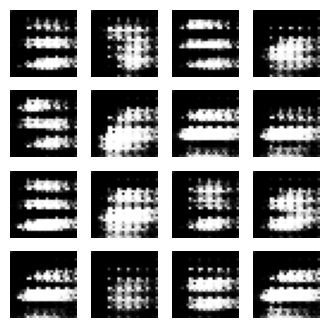

Epoch: 1


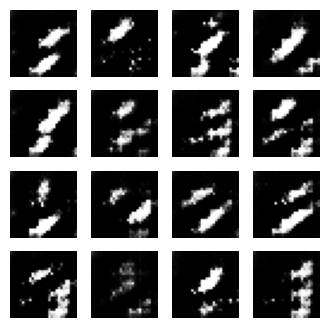

Epoch: 2


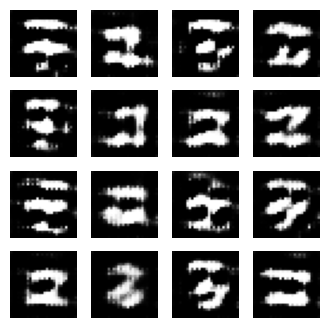

Epoch: 3


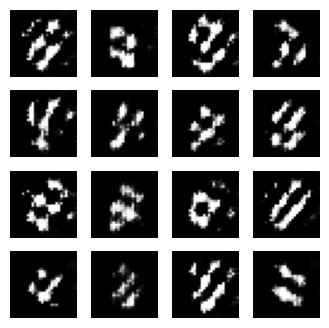

Epoch: 4


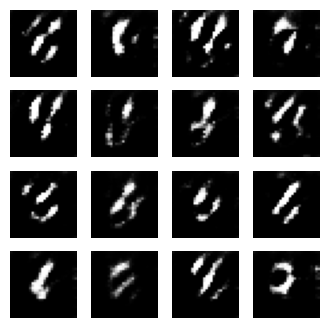

Epoch: 5


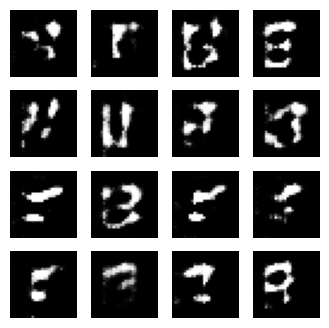

Epoch: 6


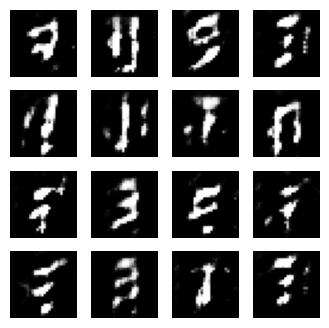

Epoch: 7


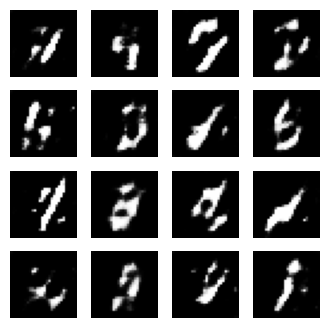

Epoch: 8


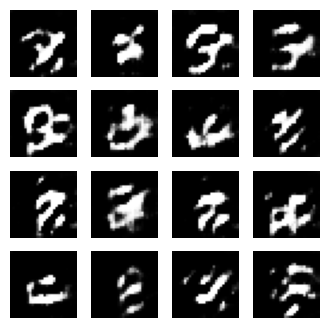

Epoch: 9


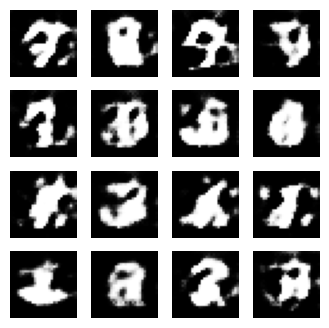

Epoch: 10


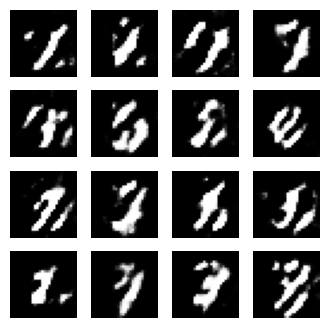

Epoch: 11


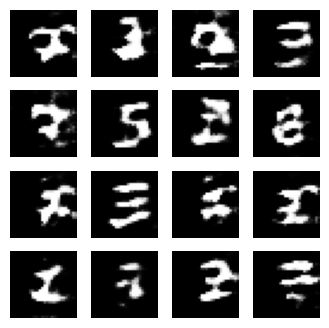

Epoch: 12


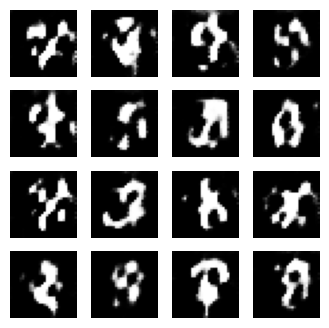

Epoch: 13


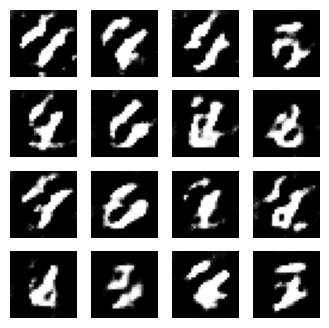

Epoch: 14


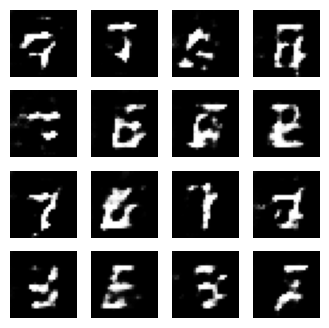

Epoch: 15


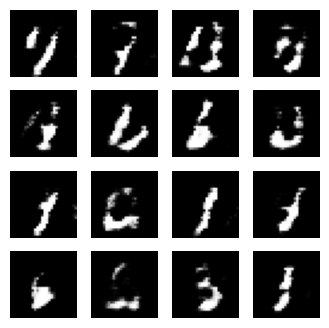

Epoch: 16


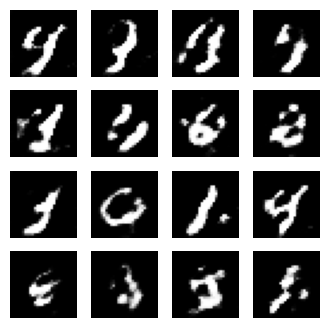

Epoch: 17


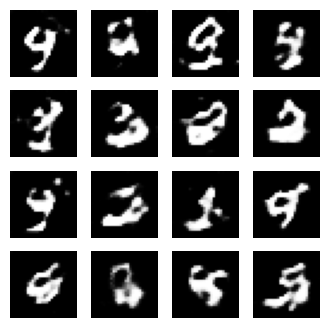

Epoch: 18


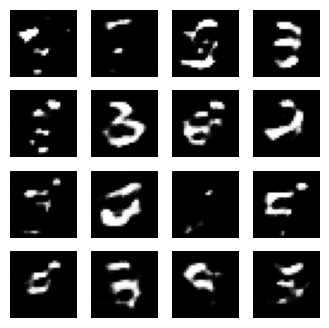

Epoch: 19


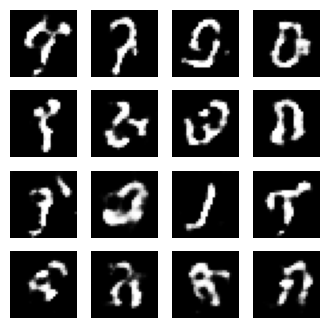

Epoch: 20


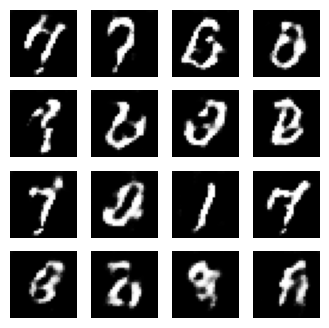

Epoch: 21


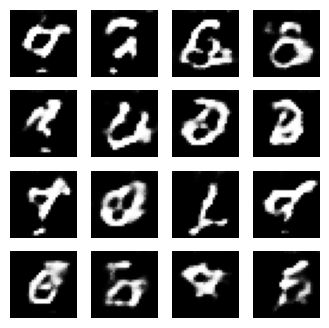

Epoch: 22


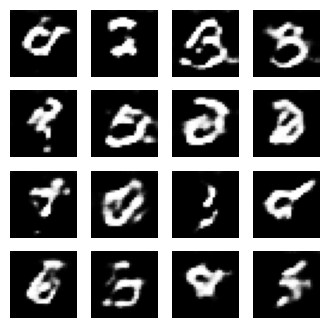

Epoch: 23


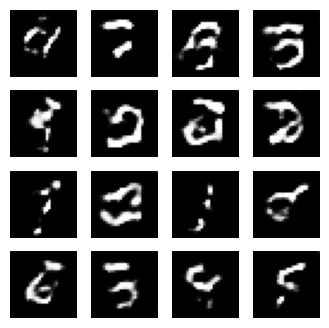

Epoch: 24


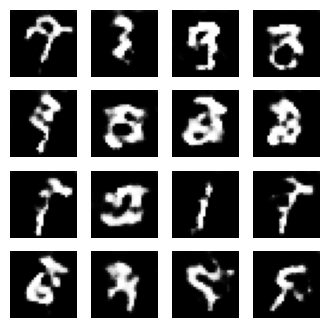

Epoch: 25


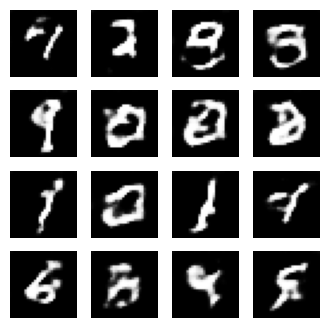

Epoch: 26


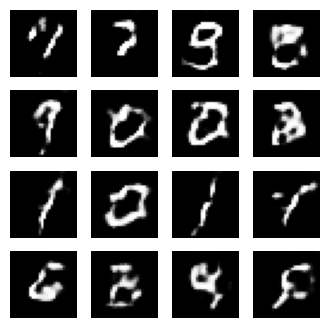

Epoch: 27


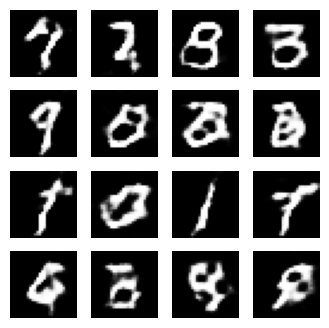

Epoch: 28


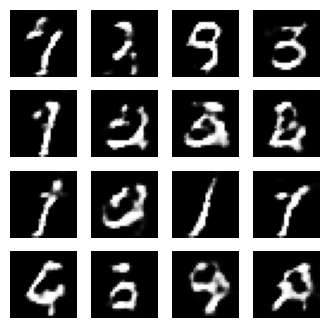

Epoch: 29


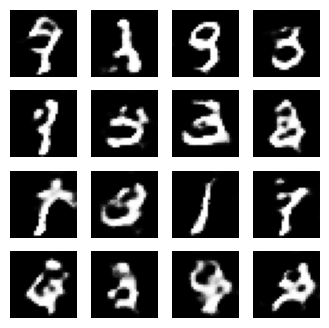

Epoch: 30


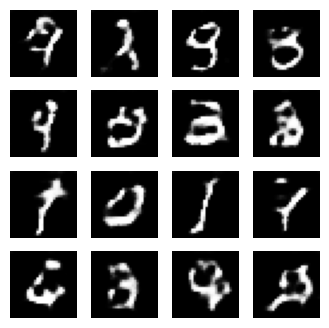

Epoch: 31


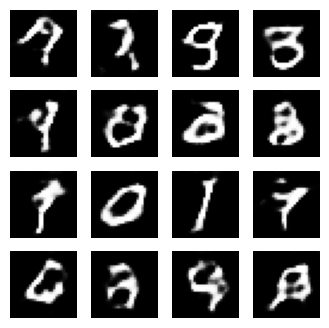

Epoch: 32


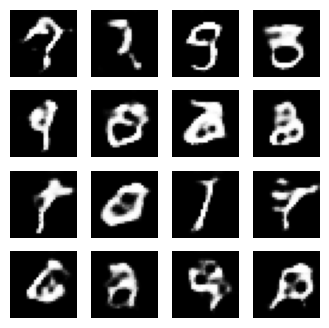

Epoch: 33


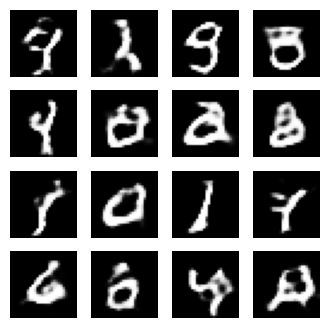

Epoch: 34


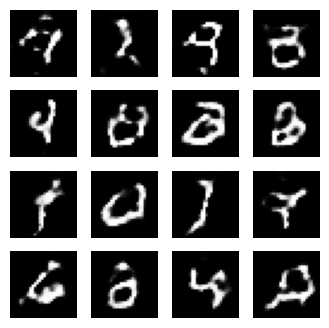

Epoch: 35


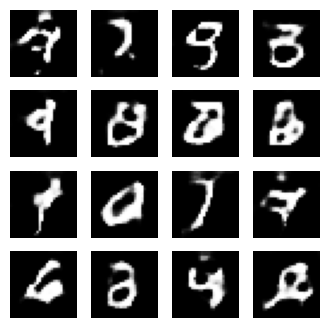

Epoch: 36


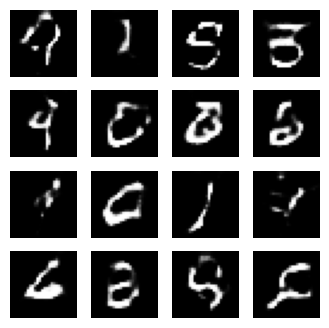

Epoch: 37


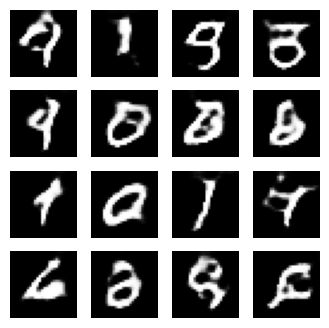

Epoch: 38


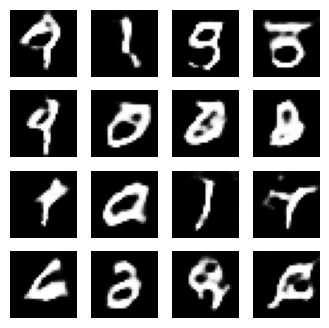

Epoch: 39


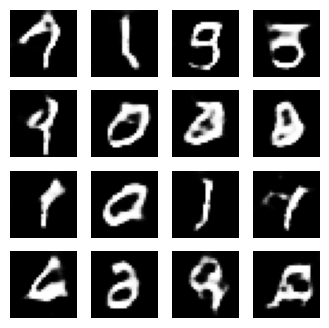

In [18]:
for epoch in range(40):
    for train_x in train_dataset:
        train_step(train_x)

    print(f'Epoch: {epoch}')
    generate_and_save_images(generator, epoch, fixed_noise)

## The latent GAN space

Recall how we for autoencoders, especially variational autoencoders (VAEs), were able to interpolate over the latent space to gradually change the contents of an image?

This is also something we can do with GANs. However, compared to VAEs, and especially $\beta$-VAEs, it is difficult to achieve as disentangled results.

## Latent space

The result of linearly interpolating over the latent space for a GAN trained on MNIST.

<img src="./graphics/goodfellow-et-al-14-fig-3.png" alt="Drawing" style="width: 800px;"/>

Source: "Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., ... & Bengio, Y. (2014). Generative adversarial nets. In Advances in neural information processing systems (pp. 2672-2680)."

## Exercises

1. Train a GAN on CIFAR-10 to generate images.
1. Generate images using your trained GAN, interpolating over the latent space. Does it appear meaningful? Try such things as changing only one of the dimensions and keeping the rest fixed, trying to find an interpretation of the specific factor.
1. (Bonus): Modify your GAN to be conditional. This means that the label information should now be provided as one of the inputs for the generator and as one of the targets for the discriminator.

**Note**: You are unlikely to have time for the training to take place during class, so treat the exercise primarily as reaching the point where training is possible. Then, you can take the time at a later point. Try to solve **1** up to the point where training can start, and then use the rest as additional exercises post-lecture.

**Hint**: You may use the notebook I have uploaded under this lecture as a starting point (exercise-gan-dcgan.ipynb). It provides some of the code, and you then have to fill in the rest. You do not have to use it - it is there if you think it might be helpful!

## Some examples from CIFAR-10 - can you tell which are fake?

**Answer**: Look for "off" pixels.

<img src="./graphics/figure_8-18.png" alt="Drawing" style="width: 1000px;"/>
Source: "DLWP"

# CycleGAN

CycleGAN is a dramatic variant of GANs where *two* generators and *two* discriminators battle (*four* total networks), while an additional objective of "cycle consistency" is imposed on the generators.

The idea is extemely elegant. Often, you might have two sets of images that are *unpaired*. For example:
1. Images you have taken at day-time.
1. Images you have taken at night-time.

Suppose you are interested in having a day-time version of one of your night-time images, or vice versa. You cannot train this directly, as you do not have two versions of each image (both a day and night time version). *However*, what about training a generator to *transform* a day-time image to a night-time image to fool a discriminator trying to distinguish between real and fake night-time photos? This is the fundamental idea of CycleGAN, but extended to go "in both directions".

CycleGAN is due to "Zhu, J. Y., Park, T., Isola, P., & Efros, A. A. (2017). Unpaired image-to-image translation using cycle-consistent adversarial networks. In Proceedings of the IEEE international conference on computer vision (pp. 2223-2232)".

## Some CycleGAN results

<img src="./graphics/zhu-et-al-18-fig-1.png" alt="Drawing" style="width: 1000px;"/>

Source: "Zhu, J. Y., Park, T., Isola, P., & Efros, A. A. (2017). Unpaired image-to-image translation using cycle-consistent adversarial networks. In Proceedings of the IEEE international conference on computer vision (pp. 2223-2232)"

## Prior to CycleGAN, similar tasks were solved but with paired data

<img src="./graphics/zhu-et-al-18-fig-2.png" alt="Drawing" style="width: 800px;"/>

<sup> Source: "Zhu, J. Y., Park, T., Isola, P., & Efros, A. A. (2017). Unpaired image-to-image translation using cycle-consistent adversarial networks. In Proceedings of the IEEE international conference on computer vision (pp. 2223-2232)"</sub>

## CycleGAN in more details

Suppose you have two sets of images, $X$ and $Y$. These do not have to contain an equal amount of images. Let $D_X$ and $D_Y$ be the discriminators attempting to distinguish between real and fake version of $X$ and $Y$, respectively. Let $G$ be the generator attempting to map $X$ to $Y$ and $F$ be the generator attempting to map $Y$ to $X$. The purpose of each network is then:

1. $G$: Take an image from $X$ and transform it to look like an image from $Y$. Further, this transformed image should be able to be mapped back (by $F$) to the original image. That is, $x\simeq F(G(x)),\,x\in X$.
1. $F$: Take an image from $Y$ and transform it to look like an image from $X$. Further, this transformed image should be able to be mapped back (by $G$) to the original image. That is, $y\simeq G(F(y)),\,y\in Y$.
1. $D_X$: Discriminate between real and fake images of type $X$.
1. $D_Y$: Discriminate between real and fake images of type $Y$.

That is, we have two types of losses. The "standard" GAN loss, as well as a "cycle-consistency loss". The first part ensures we can properly create an image of the new domain, and the second part ensures we still maintain the original contents of the images (otherwise we could not map it back).

## Graphical representation of CycleGAN

<img src="./graphics/zhu-et-al-18-fig-3.png" alt="Drawing" style="width: 1000px;"/>

<sup> Source: "Zhu, J. Y., Park, T., Isola, P., & Efros, A. A. (2017). Unpaired image-to-image translation using cycle-consistent adversarial networks. In Proceedings of the IEEE international conference on computer vision (pp. 2223-2232)"</sup>

## CycleGAN reconstructions

<img src="./graphics/zhu-et-al-18-fig-4.png" alt="Drawing" style="width: 600px;"/>

<sup> Source: "Zhu, J. Y., Park, T., Isola, P., & Efros, A. A. (2017). Unpaired image-to-image translation using cycle-consistent adversarial networks. In Proceedings of the IEEE international conference on computer vision (pp. 2223-2232)"</sup>

## CycleGAN with identity loss added for maintaining color

<img src="./graphics/zhu-et-al-18-fig-9.png" alt="Drawing" style="width: 800px;"/>

<sup> Source: "Zhu, J. Y., Park, T., Isola, P., & Efros, A. A. (2017). Unpaired image-to-image translation using cycle-consistent adversarial networks. In Proceedings of the IEEE international conference on computer vision (pp. 2223-2232)" </sup>

## Trying it for yourself

CycleGAN is *not* fast to train, but it is quite exciting and fun to imagine the things you might be able to use it for.

If you are interested, I suggest you check out the excellent tutorial at https://www.tensorflow.org/tutorials/generative/cyclegan, using Colab (unless you have a very fast computer). 

It will take you through a classical example (horses and zebras), after which you might be able to use it on some of your own data, for example using photos you have taken on your phone.

The network you will come up with won't be amazing, but the tutorial has a few suggestions for how you might improve it.

## Scaling up GANs and stability

As previously mentioned, GANs are unstable to train, being prone to rapidly deteriorate.

Further, generating large-scale images, especially with conditional GANs, is not trivial and brings additional stability problems.

These are the issues tackled by "BigGAN" in "Brock, A., Donahue, J., & Simonyan, K. (2018). Large scale gan training for high fidelity natural image synthesis. arXiv preprint arXiv:1809.11096". They stress three contributions:
1. Show that GANs benefit from scaling, and provides architectural changes to make this more feasible.
1. Introduce a "truncation trick" to trade-off between sample variety and fidelity.
1. Explore instabilities of GAN training specifically for large GANs, and provide some techniques to help avoid collapse.

Let us dive a bit more into **2** and **3**.

## Truncation of conditional GANs

**Panel a**: From left to right: The result of more truncation (drawing from a "smaller" range). Notice how diversity decreases (they all end up as more or less the same image).
<br>
**Panel b**: Results of truncation when applied to a poorly conditioned model.

<img src="./graphics/brock-et-al-19-fig-2.png" alt="Drawing" style="width: 1000px;"/>

Source: "Brock, A., Donahue, J., & Simonyan, K. (2018). Large scale gan training for high fidelity natural image synthesis. arXiv preprint arXiv:1809.11096"

## The sample variety and fidelity tradeoff

1. Low probability density region in the latent space z may not have enough training data to learn it accurately. So when generating images, we can avoid those regions to improve the image quality at the cost of the variation. i.e. the quality of images will increase but those generated images will have lower variance in style. 
2. There are different techniques to truncate the input latent space z. 
3. The general principle is when values fall outside a range, it will be resampled or squeeze to the higher-probability region.

<sup> Source: https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b </sup> 

## Tracking collapse

Let us ask: *How do we know that collapse occurs?*

This is not trivial to answer. You might be tempted to say "when the quality of the generated images deteriorates", which is correct but not immediately helpful, as I would ask back "when do we know when the quality of the images deteriorates?"

We cannot simply look at the loss of the generator or the accuracy of the discriminator to answer this question, as (using the loss of the generator as an example) the metric deteriorates for one or both of the following reasons:
1. The generator gets worse.
1. The discriminator gets better.

The first case is bad, whereas the second need not be.

This has motivated various measures that are informative about collapse and also feasible to calculate. The authors of BigGAN find the top three singular value of each weight matrix particularly informative and track these while training.

## Top singular values and collapse

<img src="./graphics/brock-et-al-19-fig-3.png" alt="Drawing" style="width: 1000px;"/>

<sup> Source: "Brock, A., Donahue, J., & Simonyan, K. (2018). Large scale gan training for high fidelity natural image synthesis. arXiv preprint arXiv:1809.11096" </sup>

## Top singular values and collapse

<img src="./graphics/SVD.jpg" alt="Drawing" style="width: 800px;"/>

<sup> Source: "Brock, A., Donahue, J., & Simonyan, K. (2018). Large scale gan training for high fidelity natural image synthesis. arXiv preprint arXiv:1809.11096" </sup>

## Whose fault is it? 

***Does instability (and collapse) occur due to the generator or the discriminator?***

The authors find that instability is neither solely due to the generator or the discriminator, but rather the adversarial training process.

This is perhaps not terrible surprising. The training process is characterized by non-stationarity, and so one model might affect the other in a way that "throws it off". As an example, imagine the following scenario (which is not unrealistic):
1. The generator discovers a "trick" (perhaps a certain color scheme or geometric pattern) that throws the discriminator off completely.
1. This results in very large gradients, and hence updates, for the discriminator. It now focuses almost solely on solving this "trick".
1. This in turn throws the generator off. It is suddenly judged not on whether it produces realistic images, but rather how well it performs its new "trick".
1. Before you know it, every image is a yellow pattern of triangles.

## How to handle collapse?

We may broadly approach collapse in three ways:
1. Try to stabilize the training process so collapse never occurs. However, this has the tendency to incur a dramatic cost in performance. Training is stable, but we never get very good results.
1. Track models and "roll back" when collapse occurs, trying to change settings to remedy the situation. However, this often either still leads to collapse or a dramatic cost in performance.
1. Live with eventual collapse, and simply use the best model before collapse occured - i.e. a form of "early stopping". This is what the authors suggest.

## Some BigGAN results

<img src="./graphics/brock-et-al-19-fig-1.png" alt="Drawing" style="width: 1000px;"/>

Source: "Brock, A., Donahue, J., & Simonyan, K. (2018). Large scale gan training for high fidelity natural image synthesis. arXiv preprint arXiv:1809.11096"

## Advantages and disadvantages of GANs

Advantages
1. GANs are extremely powerful at generating realistic, artificial data in a wide range of settings, achieving SOTA in many settings, particularly image generation.
1. GANs can use arbitrary prior distributions (as opposed to variational autoencoders) and are able to handle multi-modal distributions.
1. GANs do not require any examples of the images it should produce, only a *domain* of images (in which the generator should fool the discriminator). Used cleverly (such as in CycleGAN), this allows one to solve tasks where the required data to solve them in a supervised fashion is not only difficult to obtain, but do not exist (such as zebras and horses).

Disadvantages
1. GANs are difficult to train, and during training issues related to cycling, mode collapse, and instability may occur.
1. It is not possible to generate discrete data (as we need to backpropagate through it).
1. The latent space is not as disentangled as for ($\beta$-variational) autoencoders.

## Summary and looking ahead

In these lectures, we have learned what GANs are, including what types of problems may be solved using GANs and the role of the generator and discriminator.

Further, we have considered in some details the challenges associated with training GANs, and how these may be approached.

This concludes the lectures of this course, leaving us with the exam next month.

I have added a few slides that **are not part of the curriculum of this course**, but which some of you may be interested in.

## Additional comments on training

There are two widely applied methods/techniques for training we have not covered in this course, but which may be of interest to some of you.

1. **Learning rate scheduling**. The learning rate does not have to be kept fixed during training. Indeed, it is very normal to at least lower the learning rate during training, and sometimes a "warm-up" phase is used, where the learning rate is gradually increased at the very start of training (and then gradually decreased for the rest of training). See https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler.
1. **Gradient clipping**. Sometimes, some of the gradients during training may be very large, which could result in undesirably large weight updates. A simple way to solve this problem is to set a maximum threshold on the gradients. If any gradient is above this, we reduce it to the threshold before updating the weights. See individual optimizers for how to do this, such as https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam for the Adam optimizer.

## Additional comments on hyperparameter optimization

We have used optimization of hyperparameters throughout this course, but only as an auxiliary tool - this course was never about hyperparameter optimization, which could be a whole course on its own!

Nonetheless, I think in particularly the following may be of interest to some of you.

1. **Keras Tuner**. TensorFlow comes with its own excellent tool for hyperparameter optimization in the form of the Keras Tuner. See https://www.tensorflow.org/tutorials/keras/keras_tuner for an excellent introduction. 
1. **Hyperopt**. Hyperopt is a library for implementing many great optimization algorithms, such as tree-structured Parzen estimators. Not only do I love it, Francois Chollet mentions it as one of his favorite tools as well. See https://hyperopt.github.io/hyperopt/.
1. **Optuna**: An alternative to Hyperopt is Optuna. I do not have experience with it myself, but it seems great. See https://optuna.org/.